In [235]:
#Import and set magics
import numpy as np
%matplotlib inline
import pandas as pd
import datetime
import pandas_datareader
import pydst
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import scipy as sp
from scipy import stats
from scipy import optimize
from scipy import interpolate
from scipy import linalg
import sympy as sm
import math

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
%matplotlib inline
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot


# Estimating income processes


Consider $N$ households indexed by $i$ who are in the labor market for $T$ periods indexed by $t \in ${1,2,...,T}$,

Their **wage income** is stochastic and given by,
 
$P_{i,t}$ = $\psi_{i,t}$ $P_{i,t-1}$

$\tilde{Y}_{i,t}$ = $xi_{i,t}$ $P_{i,t}$

$Y_{i,t}$ = \left\begin{array}{rcl}$
            \overline{\overline{0}+\text{if}\mu_{i,t}<\pi}
            \\tilde{Y}_{i,t} +\text{else}
            \end{array}\right.


   


$\psi_{i,t}$ ~ LogNormal(-0.5$\sigma_{\psi}^2$,$\sigma_{\psi})$

$\xi_{i,t}$ ~ LogNormal(-0.5$\sigma_{\xi}^2$,$\sigma_{\xi})$

$\mu_{i,t}$ ~ $Uniform(0,1)$


$P_{0} = 1$
   
where

$\sigma_{\psi}$ is the standard deviation of the *permanent* shocks, $\psi_{i,t}$

$\sigma_{\xi}$ is the standard deviation of the *transitory* shocks, $\xi_{i,t}$

$\pi$ is the risk of unemployment

The data you have access to is:


In [87]:
import numpy as np
dataY = np.load(r'C:\Users\musse\Documents\GitHub\projects-2020-zjr-hrv\projects-2020-zjr-hrv\dataY.npy')
T,N = dataY.shape
print(dataY)
print(dataY.shape)




[[0.83317569 0.72881172 0.         ... 1.16771806 0.93207083 0.86711803]
 [1.18542294 0.92826337 1.62913142 ... 1.13903869 0.94479246 0.78842682]
 [1.14813596 0.90542496 0.70634401 ... 1.49584791 1.08969956 0.        ]
 ...
 [0.73818651 0.59958039 0.56135238 ... 2.60075173 1.07070489 0.43010036]
 [1.14130879 0.85728537 0.54530761 ... 3.79294856 0.67764143 0.38720822]
 [0.64908127 0.85101393 0.59517395 ... 3.32800991 0.82400879 0.5814573 ]]
(20, 50000)


**Question 1:** Calculate income growth rates as log-changes

In [102]:
#Defining income growth rate by finding the first differences. Thereafter replacing the negative Y-values with .nan

logY = np.diff(np.log(dataY))
#diff_dataY = np.diff(dataY) 
  
# printing initial arrays 
print("Initial diff", logY) 
  
# code to replace all negative value with 0 
logY[logY<=0] = np.nan
  
# printing result 
print("New resulting diff: ", logY) 






initial diff [[-0.13382911        -inf         inf ...  0.45991757 -0.22539794
  -0.0722337 ]
 [-0.2445394   0.56248678 -0.45247293 ...  0.10650339 -0.18697465
  -0.18092569]
 [-0.2374906  -0.24830202  0.49367077 ...  0.38133059 -0.31679118
         -inf]
 ...
 [-0.20796646 -0.06588123  0.6550227  ...  1.08826931 -0.88748332
  -0.9120539 ]
 [-0.2861601  -0.45242079  0.43603115 ...  1.35354726 -1.7222807
  -0.5596557 ]
 [ 0.27087056 -0.35757477  0.31896575 ...  1.52939372 -1.39594858
  -0.34864367]]
New resulting diff:  [[       nan        nan        inf ... 0.45991757        nan        nan]
 [       nan 0.56248678        nan ... 0.10650339        nan        nan]
 [       nan        nan 0.49367077 ... 0.38133059        nan        nan]
 ...
 [       nan        nan 0.6550227  ... 1.08826931        nan        nan]
 [       nan        nan 0.43603115 ... 1.35354726        nan        nan]
 [0.27087056        nan 0.31896575 ... 1.52939372        nan        nan]]


**Question 2:** Calculate the following 3 statistics from the data:

$s_{1}$: Share of observations with $Y_{i,t}$=0

$s_{2}$: Variance of income growth rate, Var($\Delta$ Log $Y_{i,t}$)

$s_{3}$: Covariance of income growth rates one period apart, Cov($\Delta$ Log $Y_{i,t}$,$\Delta$ Log $Y_{i,t-1}$ )

To count shares of observations with $Y_{i,t}$=0, we use the nonzero-function

In [103]:
#S1:
print('Number of observations with Y=0 is') 
np.count_nonzero(dataY==0)



Number of observations with Y=0 is


49925

The variance is calculated by the mean of square minus the square of the mean, i.e.

$Var(x)=E[(X-\mu)^{2}]$



In [104]:
#S2:
print(np.var(logY))

nan


As seen above, the variance results in "nan", meaning we would have to remove the nan values from our sample to find a value for the variance. Hence, we find:

In [175]:
diffY = diff_dataY[~np.isnan(diff_dataY)]
print('The variance is' ,np.var(diffY))

The variance is 0.15780801990005514


Finally, the Covariance is found by $cov(X,Y)$ = $E[(X-E[X])(Y-E[Y])]$

In [173]:
print('The covariance is' ,np.cov(diffY)) 

The covariance is 0.15780833423674454


Question 3: Simulate the income process using your own choice of $\sigma_{\psi}$, $\sigma_{\xi}$, $\pi$, T and N. Calculate the 3 same statistics. Compare with the data statistics

In [155]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from numba import njit

#Simulated figures
T = 50
N = 1000
pi = 0.3
s_psi = 0.23
s_xi = 0.4

#Model
psi = np.random.lognormal(-0.5 * s_psi, s_psi, 1000)
xi = np.random.lognormal(-0.5 * s_xi,s_xi, 1000)
P_0 = 1
P = psi * P_0
Y_tilde = xi * P
mu = np.random.uniform(0,1)




#Defining Y
def income(Y): 
    if mu < pi:
        Y=0 
    else :
        Y = Y_tilde

@njit
def time_path(T):
    w = np.random.randn(T+1)  # w_0, w_1, ..., w_T
    w[0] = 0
    P = np.zeros(T+1)
    for t in range(1, T+1):
        P[t] = w[1:t].sum()
   
    return  P





In [167]:
#first differences and log on Y_tilde
logY_tilde = np.diff(np.log(Y_tilde))
 
  
# printing initial arrays 
print("New diff", Y_tilde) 


New diff [1.40621881 0.54048955 0.54179175 1.95778514 0.48098441 1.02204343
 0.56065372 0.45678314 1.4012769  1.07185749 0.66387897 0.43474994
 1.69449106 0.65990448 1.43611859 1.0486678  0.6389541  0.75817993
 0.77768874 0.26117108 0.63485198 0.72351503 0.29755991 0.85033572
 0.90537297 0.68443236 0.4843746  0.41602903 0.77060337 0.45026695
 0.62231064 1.10333521 1.24327665 0.4435823  0.66380278 1.25164183
 0.67046208 1.75695946 0.51807955 0.65137344 0.41671247 1.06367206
 0.68625497 0.54640242 0.44766844 1.58956475 0.45661953 0.46751715
 0.66294205 0.48580823 1.47387004 0.75557703 0.39891727 0.54091915
 0.7912065  0.60601093 1.03654421 0.58859634 0.54036999 0.61029904
 0.64314654 0.43379369 1.20303044 0.78194505 0.35009648 0.30417106
 1.05703481 0.53842165 0.68993374 0.60350681 0.5535549  0.69250946
 1.18518063 0.52713092 0.68251296 1.56109525 0.512705   0.61226224
 0.54761124 0.93414775 0.5919211  0.65319408 0.84141781 0.77557177
 0.69516354 0.76796995 0.46909983 0.37178671 0.890989

In [168]:
#Calculating s1_sim
print('Number of observations with Y=0 is') 
np.count_nonzero(logY_tilde==0)

Number of observations with Y=0 is


0

In [169]:
#Calculating s2_sim
print(np.var(logY_tilde))

0.44214824517553175


In [170]:
#Calculating s3_sim
np.cov(logY_tilde)

array(0.44259128)

Comparison of the simulated data and the factual dataset

s1_sim =0
s1_data = 49925
s2_sim = 0.44214824517553175
s2_data = 0.15780801990005514
s3_sim = 0.44259128
s3_data = 0.15780833423674454

**Question 4:** Solve the following minimization problem to estimate $\sigma_{\psi}$, $\sigma_{\xi}$ and $\pi$ 

$\sigma_{\psi}^*$, $\sigma_{\xi}^*$, $\pi^*$ = $arg_{\sigma_{\psi}>=0,\sigma_{\xi}>=0,\pi\in [0,1]}$               min $(s_{1}^{sim}-s_{1}^{data})^2$ + $(s_{2}^{sim}-s_{2}^{data})^2$ + $(s_{3}^{sim}-s_{3}^{data})^2$

where for each new guess of $\sigma_{\psi}$, $\sigma_{\xi}$ and $\pi$ you should be re-simulating the data with the same seed and re-calculate the 3 statistics

In [176]:
#Defining s
s1_sim = 0
s1_data = 49925
s2_sim = 0.44214824517553175
s2_data = 0.15780801990005514
s3_sim = 0.44259128
s3_data = 0.15780833423674454

np.random.seed(100)
# Define a function that,
def f(x):
    x = (s1_sim-s1_data)**2+(s2_sim-s2_data)**2+(s3_sim-s3_data)**2
    # Outputs x multiplied by a random number drawn from a normal distribution
    return x * np.random.normal(size=1)[0]

# Create some values of x
xs = [1,2,3,4,5,6]
#Define argmin that
def argmin(f, xs):
    # Applies f on all the x's
    data = [f(x) for x in xs]

    # Finds index of the smallest output of f(x)
    index_of_min = data.index(min(data))
        
    # Returns the x that produced that output
    return xs[index_of_min]
# Run the argmin function
argmin(f, xs)

print('x','|', 'f(x)')
print('--------------')
for x in xs:
    print(x,'|', f(x))


x | f(x)
--------------
1 | 551291569.7058002
2 | -2667089020.6084995
3 | -472319424.2715019
4 | 635592534.2758255
5 | -1141634837.841262
6 | 1084647442.0114043


In [124]:
def objective(x):
 pass
res = optimize.minimize(objective,x,method='L-BFGS-B',bounds=(-3,3),args=(-3,3),options={'eps': 1e-4})


contour()

NameError: name 'x' is not defined

# Wealth in the utility function

In the final period, t=T, the household solves the following problem:



$$
\begin{aligned}
v_{T}(a_{T-1})&= \max_{c_{T}}\frac{(c_{T}^{1-\rho})}{1-\rho} + \kappa \frac{(a_{T}+a\underline)^{1-\sigma}}{1-\sigma} \\
\text{s.t.} \\
a_{T} = (1+r)a_{T-1}+y-c_{T}
\end{aligned}
$$

where 

 * $a_t$ is end-of-period assets in period $t$
 * $c_t$ is consumption in period $t$
 * $\rho$ is the CRRA-coefficient for consumption utility
 * $\sigma$ is the CRRA-coefficient for wealth utility
 * $\underline{a}$ is an *additive* scaling factor for wealth utility
 * $\kappa$ is a *multiplicative* scaling factor for wealth utility
 * $r$ is the rate of return
 * $y$ is income
  
The optimal **consumption function** is denoted $c_t^{*}(a_{t-1})$

The optimal **savings function** is denoted $a_t^{*}(a_{t-1}) = (1+r)a_{t-1} + y - c_t^{*}(a_{t-1})$.
  

In [260]:
# a. parameters
rho = 2.0
sigma = 1.2
kappa = 0.6
a_ubar = 2.0
r = 0.04
y = 1.0
# b. grids
a_lag_vec = np.linspace(0,300,300)



**Question 1:** Find and plot the functions $v_{T}(a_{T-1})$, $c_T^{*}(a_{T-1})$, and $a_T^{*}(a_{T-1})$
 

In [261]:
#Value function last period

def utility(c,rho):
    return c**(1-rho)/(1-rho)

def bequest(kappa,a,a_ubar,sigma):
    return kappa*(a+a_ubar)**(1-sigma)/(1-sigma)

def v2(c2,a2,a_ubar2,rho,kappa,sigma):
    return utility(c2,rho) + bequest(a2,a_ubar2,kappa,sigma)

In [280]:
#Value function first period
def v1(c1,a_lag_vec, a_ubar1,rho,beta,r,y,v2_interp):
    
    # a. v2 value, if low income
    a2_low = (1+r)*a_lag_vec + y - c1
    v2_low = v2_interp([a2_low])[0]
    
    # b. v2 value, if high income
    a2_high = (1+r)*a_lag_vec + y - c1
    v2_high = v2_interp([a2_high])[0]
    
    # c. total value
    return utility(c1,rho) + v2*beta

(0, 100)

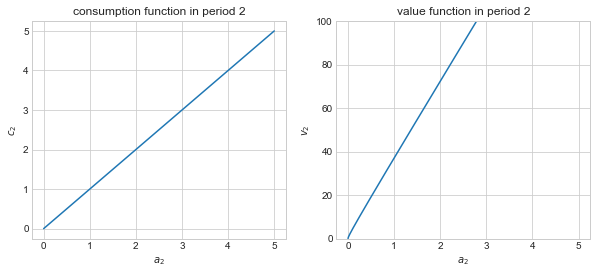

In [281]:
def solve_period_2(rho,kappa,sigma,beta):

    # a. grids
    a2_vec = np.linspace(1e-8,5,500)
    v2_vec = np.empty(500)
    c2_vec = np.empty(500)

    # b. solve for each m2 in grid
    for i,a2 in enumerate(a2_vec):

        # i. objective
        obj = lambda x: -v2(x[0],a2,rho,kappa,sigma,beta)

        # ii. initial value (consume half)
        x0 = a2/2

        # iii. optimizer
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-8,a2),))

        # iv. save
        v2_vec[i] = -result.fun
        c2_vec[i] = result.x
        
    return a2_vec,v2_vec,c2_vec

# solve
a2_vec,v2_vec,c2_vec = solve_period_2(rho,kappa,sigma,beta)

# illustration
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(a2_vec,c2_vec)
ax.set_xlabel('$a_2$')
ax.set_ylabel('$c_2$')
ax.set_title('consumption function in period 2')

ax = fig.add_subplot(1,2,2)
ax.plot(a2_vec,v2_vec)
ax.set_xlabel('$a_2$')
ax.set_ylabel('$v_2$')
ax.set_title('value function in period 2')
ax.set_ylim([0,100])


In [282]:
#Interpolator

v2_interp = interpolate.RegularGridInterpolator([a2_vec], v2_vec,
                                                bounds_error=False,fill_value=None)

In all periods *before the last*, $t < T$, the household solves:
 
 

$v_{t}(a_{t-1})$ = $max_{c_{t}} \frac{c_t^{1-\rho}}{1-\rho} + \kappa \frac{(a_t+\underline{a})^{1-\sigma}}{1-\sigma} + \beta v_{t+1}(a_t)$

{s.t.} 
    $a_{t} = (1+r)a_{t-1} + y - c_{t}$

where $\beta$ is the discount factor for future utility.

**Question 2:** Find and plot $v_{T-1}(a_{T-2})$ and  $c_{T-1}^{*}(a_{T-2})$.


In [283]:
beta = 0.97
T = 20


In [284]:
# grids
m1_vec = np.linspace(1e-8,10,100)
a2_vec = np.linspace(1e-8,10,100)


def solve_period_1(rho,beta,r,y,v2_interp):

    # a. grids
    a_lag_vec = np.linspace(0,300,300)
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,a1 in enumerate(a1_vec):
        
        # i. objective
        obj = lambda x: -v1(x[0],a1,rho,beta,r,y,v2_interp)
        
        # ii. initial guess (consume half)
        x0 = a1/2
        
        # iii. optimize
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-12,a1),))
        
        # iv. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x[0]
     
    return a1_vec,v1_vec,c1_vec

# solve
a1_vec,v1_vec,c1_vec = solve_period_1(rho,beta,r,y,v2_interp)

# illustrate
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(a1_vec,c1_vec)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption function in period 1')

ax = fig.add_subplot(1,2,2)
ax.plot(a1_vec,v1_vec)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$v_1$')
ax.set_title('value function in period 1')
ax.set_ylim([-40,1]);


TypeError: v1() missing 1 required positional argument: 'v2_interp'

**Question 3:** Find $c_t^{*}(a_{t-1})$ for $t \in {0,1,...,T}$ and plot them in a single figure.


 


In [249]:
def solve(rho,beta,r,Delta,nu,kappa):
    
    # a. solve period 2
    a2_vec,v2_vec,c2_vec = solve_period_2(rho,nu,kappa,Delta)
    
    # b. construct interpolator
    v2_interp = interpolate.RegularGridInterpolator([a2_vec], v2_vec,
        bounds_error=False,fill_value=None)
    
    # c. solve period 1
    a1_vec,v1_vec,c1_vec = solve_period_1(rho,beta,r,Delta,v2_interp)
    
    return a1_vec,c1_vec,a2_vec,c2_vec

    #plotting consumption level for various levels of consumption
    fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for Delta in [0.05,0.15,0.25]:
    a1_vec,c1_vec,a2_vec,c2_vec = solve(rho,beta,r,Delta,sigma,kappa)
    ax.plot(a1_vec,c1_vec,label=f'$\Delta = {Delta}$')

ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$a_1$')
ax.set_ylabel('$c_1$')
ax.set_title('value function in period 1')
ax.set_xlim([0,2])
ax.set_ylim([0,1.5]);

TypeError: unsupported operand type(s) for *: 'function' and 'float'

Define the saving rate as:

$s_{t}^* (a_{t-1})$ = $\frac{(a_{t}-a_{t-1}+y-c_{t}^*(a_{t-1}))-a_{t-1}}{y+ra_{t-1}}$


**Question 4:** Plot $s_0^{*}(a_{-1})$. Do the rich or the poor save the most?
   

In [250]:
Delta = 0.5
a1_vec,c1_vec,a2_vec,c2_vec = solve(rho,beta,r,Delta,sigma,kappa)

c1_interp = interpolate.RegularGridInterpolator([a1_vec], c1_vec,
                                                bounds_error=False,fill_value=None)

c2_interp = interpolate.RegularGridInterpolator([a2_vec], c2_vec,
                                                bounds_error=False,fill_value=None)

#Draw initial distribution
# a. draw initial
simN = 10000
sim_m1 = np.fmax(np.random.normal(1,0.1,size=simN),0) # "randomly" chosen distribution

# b. period 1
sim_c1 = c1_interp(sim_a1)
sim_a1 = sim_a1-sim_c1

# c. transition to period 2 with random draw
sim_a2 = (1+r)*sim_a1+np.random.choice([0.5,1.5],p=[0.5,0.5])

# d. period 2
sim_c2 = c2_interp(sim_a2)

#Plot distributions
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(sim_c1,bins=100,label='period 1')
ax.hist(sim_c2,bins=100,label='period 2')

ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$c_t$')
ax.set_ylabel('freq.')
ax.set_title('consumption')

TypeError: unsupported operand type(s) for *: 'function' and 'float'

**Question 5:** Can you change the parameter choices such that $s_0^{*}(a_{-1})$ is monotonically decreasing in $a_{-1}$?

# Refined grid search

Let $\boldsymbol{x} = \left[\begin{array}{c}
x_1 \\
x_2\\
\end{array}\right]$ be a two-dimensional vector. Consider the following algorithm:

**Algorithm:** `grid_search()`

**Goal:** Minimize the function $f(\boldsymbol{x})$.

1. Choose a grid size $N$ and minimum and maximum values of $x_{1}$ and $x_{2}$ denoted $\overline{x_{1}}$>$\underline{x_{1}}$ and $\overline{x_{2}}$>$\underline{x_{2}}$
2. Calculate step sizes 

    $\Delta_{1}$ =($\overline{x_{1}}$-$\underline{x_{1}}$)/(N-1)
    
    $\Delta_{2}$ =($\overline{x_{2}}$-$\underline{x_{2}}$)/(N-1)
3. Find the grid point with the lowest function value solving 

    $j^{*}_{1}$, $j^{*}_{2}$ = $arg_{j_{1}\in{0,...,N-1}, j_{2}\in{0,...,N-1}}$  f( $\underline{x_{1}+j_{1}$\Delta_{1}$,$\underline{x_{2}+j_{2}$\Delta_{2}$)

    
    


1. Return 


**Question 1:** Implement the grid_search() algorithm to minimize the rosen function.


In [120]:
def rosen(x):
 return (1.0-x[0])**2+2*(x[1]-x[0]**2)**2


In [122]:
def grid_search(f,x1_min,x1_max,x2_min,x2_max,N,delta1,delta2):
 return np.nan,np.nan,np.nan
# settings
x1_min = 0
x1_max = 5
x2_min = 0
x2_max = 4
N = 1000

#calculate step sizes
## delta1=(x1_max-x1_min)/(N-1)
## delta2=(x2_max-x2_min)/(N-1)
# apply grid search
x1,x2,f = grid_search(rosen,x1_min,x1_max,x2_min,x2_max,N, delta1,delta2)
print(f'minimum found at ({x1:.8f},{x2:.8f}) with the function value {f:.8f}')

minimum found at (nan,nan) with the function value nan


**Question 2:** Implement the refined_grid_search() algorithm to minimize the rosen function

In [47]:
def refined_grid_search(f,x1_min,x1_max,x2_min,x2_max,N,K):
 return np.nan,np.nan,np.nan
# more settings
K = 10
# apply refined grid search
x1,x2,f = refined_grid_search(rosen,x1_min,x1_max,x2_min,x2_max,N,K)
print(f'minimum found at ({x1:.8f},{x2:.8f}) with the function value {f:.8f}'

SyntaxError: unexpected EOF while parsing (<ipython-input-47-36645f060032>, line 7)